## Equipo: 
* Carolina Herrera Martínez
* Cutberto Arizabalo Nava
* Diego Arturo Padilla 
* Keyuan Zhao

# Contexto

Las previsiones no son sólo para los meteorólogos. Los gobiernos prevén el crecimiento económico. Los científicos intentan predecir la población futura. Y las empresas prevén la demanda de productos, una tarea habitual de los científicos de datos profesionales. Las previsiones son especialmente importantes para las tiendas de comestibles, que deben decidir con delicadeza cuánto inventario comprar. Si se predice un poco por encima, las tiendas de comestibles se quedan con un exceso de existencias de productos perecederos. Si adivinan un poco menos, los artículos más populares se agotan rápidamente, lo que supone una pérdida de ingresos y un disgusto para los clientes. Unas previsiones más precisas, gracias al aprendizaje automático, podrían ayudar a los minoristas a complacer a los clientes teniendo la cantidad justa de productos en el momento adecuado.

Los métodos actuales de previsión subjetiva para el comercio minorista tienen pocos datos que los respalden y es poco probable que se puedan automatizar. El problema se complica aún más a medida que los minoristas añaden nuevas ubicaciones con necesidades únicas, nuevos productos, gustos estacionales en constante cambio y una comercialización de productos impredecible.

# Objetivo

En esta competencia de "iniciación", utilizará la previsión de series temporales para pronosticar las ventas de las tiendas con datos de Corporación Favorita, un gran minorista de comestibles con sede en Ecuador.

En concreto, construirás un modelo que prediga con mayor precisión las ventas unitarias de miles de artículos vendidos en diferentes tiendas Favorita. Practicará sus habilidades de aprendizaje automático con un conjunto de datos de entrenamiento accesible con información de fechas, tiendas y artículos, promociones y ventas unitarias.

# Codificación

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rcParams, style
import seaborn as sns
from plotly import express as px, graph_objects as go
rcParams['figure.figsize'] = (10, 6)

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import gc
gc.enable()
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
DATA_PATH = '../input/store-sales-time-series-forecasting/'

Primero procederemos a la lectura de los datos que nos proveen para la resolución del reto

In [3]:
# Leemos train 
# Para esto, definimos que se haga un parse de las fechas.
# indicamos también que store number y family son categorías
train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv',
                    parse_dates = ['date'], infer_datetime_format = True,
                    dtype = {'store_nbr' : 'category',
                             'family' : 'category'},
                   usecols = ['date', 'store_nbr', 'family', 'sales'])
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))


train['date'] = train.date.dt.to_period('D')
# seteamos los indices y ordenamos el df en base a ellos
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()
train.head()

# leemos test
# setteamos los mismos indices que en train
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv',
                   parse_dates = ['date'], infer_datetime_format = True)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['date', 'store_nbr', 'family']).sort_values('id')
test.head()

df_stores = pd.read_csv(os.path.join(DATA_PATH, 'stores.csv'))

df_transactions = pd.read_csv(os.path.join(DATA_PATH, 'transactions.csv')).sort_values(['store_nbr', 'date'])
df_oil = pd.read_csv(os.path.join(DATA_PATH, 'oil.csv'))
df_holidays_events = pd.read_csv(os.path.join(DATA_PATH, 'holidays_events.csv'))
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date'])


hol = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv',
                  parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date').to_period('D')


Procederemos a ver si hay relaciones entre los valores de train con lás demás tablas

**Transactions**

In [4]:
df_train_temp = df_train.groupby(['date', 'store_nbr']).sales.mean().reset_index()

In [5]:
df_aux_merge = pd.merge(df_train_temp, df_transactions, how = 'left')

<AxesSubplot:>

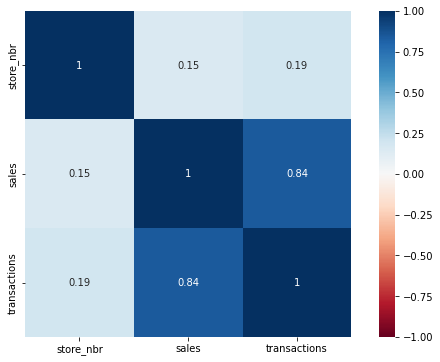

In [6]:
sns.heatmap(data=df_aux_merge.corr(), vmin=-1, vmax=1, cmap = 'RdBu', annot=True, square = True)

**Oil**

In [7]:
# vamos a tomar toda la date histórica en el df.
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')
# leemos los datos del precio del petróleo, aquí también parseamos fechas
oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv',
                  parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date').to_period('D')
# calculamos el precio promedio del petróleo. Lo calculamos de forma semanal (rolling de 7 días)
oil['avg_oil'] = oil['dcoilwtico'].rolling(7).mean()
# Metemos en nuestro calendario los valores promedio del oil 
calendar = calendar.join(oil.avg_oil)
# Nos aseguramos de llenar los Na's con el método fill forward, el cual propaga el ultimo valor válido 
calendar['avg_oil'].fillna(method = 'ffill', inplace = True)
calendar.dropna(inplace = True)
calendar.head()

,avg_oil
2013-01-10,93.218571
2013-01-11,93.284286
2013-01-12,93.284286
2013-01-13,93.284286
2013-01-14,93.470000


In [29]:
calendar

,avg_oil,oil_lags_1,oil_lags_2,oil_lags_3,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
2013-01-13,93.284286,93.284286,93.284286,93.218571,0,0,0,0,0,0,1,0,0,0,0,0,0
2013-01-14,93.470000,93.284286,93.284286,93.284286,1,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-15,93.490000,93.470000,93.284286,93.284286,1,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-16,93.644286,93.490000,93.470000,93.284286,1,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-17,93.970000,93.644286,93.490000,93.470000,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,47.720000,47.720000,47.720000,47.598571,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-08-28,47.624286,47.720000,47.720000,47.720000,1,0,0,0,0,0,0,0,0,0,0,0,0
2017-08-29,47.320000,47.624286,47.720000,47.720000,1,1,0,0,0,0,0,0,0,0,0,0,0
2017-08-30,47.115714,47.320000,47.624286,47.720000,1,0,1,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='date', ylabel='dcoilwtico'>

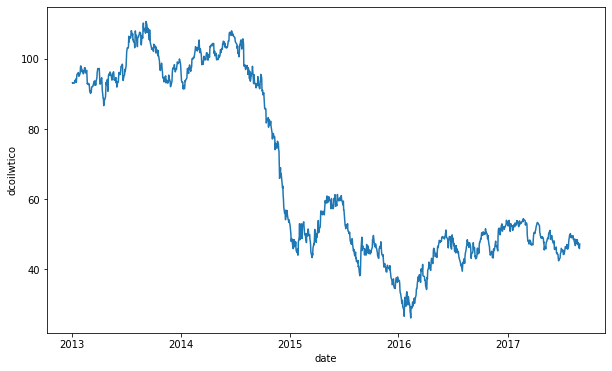

In [8]:
# graficamos el precio del petróleo
sns.lineplot(data = oil.dcoilwtico.to_timestamp())

A continuación calcularemos la autocorrelación parcial. esta es la sumatoria de las relaciones entre una observación de una serie tempral con las observaciones en timesteps previos.

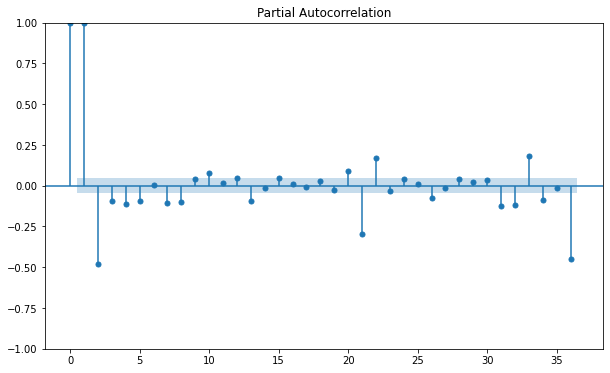

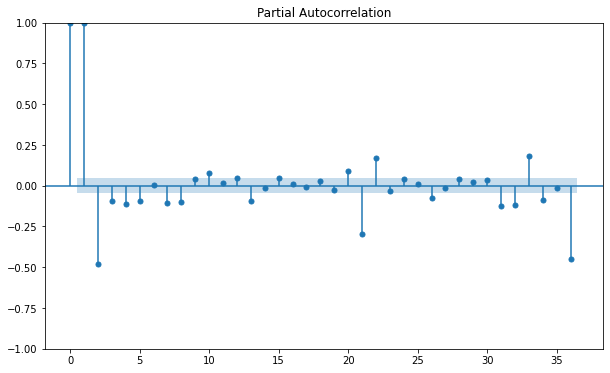

In [9]:
#calculamos la correlación parcial. lo haremos de forma anual,
# por lo que el lag es de 12 (meses)
plot_pacf(calendar.avg_oil, lags = 36)

Encontramos que hay una correlación muy fuerte solo en los primeros lags, por lo que estamos viendo un termino autoregresivo (que sus nuevos valores van a depender de sus valores previos). 
Ahora analizaremos más a detalle los primeros 3 lags, 
ya que son los que tienen un valor mayor

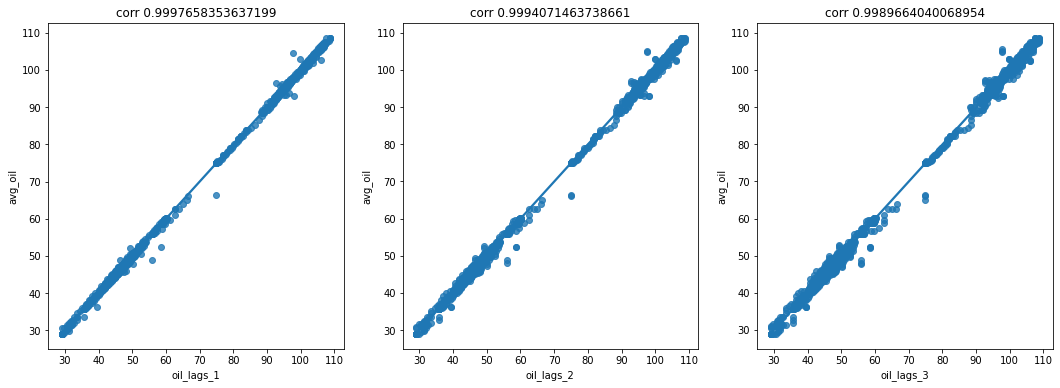

In [10]:
#iteramos del 1 al 3
for l in range(1, 3 + 1) :
    #guardamos el valor con el desplazamiento correspondiente
    calendar[f'oil_lags_{l}'] = calendar.avg_oil.shift(l)
calendar.dropna(inplace = True)
calendar.head()

lag1, lag2, lag3 = 'oil_lags_1', 'oil_lags_2', 'oil_lags_3'

fig = plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.regplot(x = calendar[lag1], y = calendar.avg_oil)
plt.title(f'corr {calendar.avg_oil.corr(calendar[lag1])}')
plt.subplot(1,3,2)
sns.regplot(x = calendar[lag2], y = calendar.avg_oil)
plt.title(f'corr {calendar.avg_oil.corr(calendar[lag2])}')
plt.subplot(1,3,3)
sns.regplot(x = calendar[lag3], y = calendar.avg_oil)
plt.title(f'corr {calendar.avg_oil.corr(calendar[lag3])}');

Se observa que el precio de la gasolina presenta correlaciones fuertes con respecto a sus periodos pasados más inmediatos

**Holidays**

In [11]:
hol.describe()

,type,locale,locale_name,description,transferred
count,350,350,350,350,350
unique,6,3,24,103,2
top,Holiday,National,Ecuador,Carnaval,False
freq,221,174,174,10,338


Vamos a eliminar tanto los locales porque son muy pocos al igual que los transferred, estos ultimos porque son dias que no fueron de descanso si no que se moviliazaron hacia otra fecha.
Nos enfocaremos en los nacionales que son el Top

In [12]:
hol = hol[hol.locale == 'National'] # Vamos a enforcarnos en las nacionales
hol = hol.groupby(hol.index).first() # Y vamos a eliminar los duplicados dejando solo el primero de ellos


# Creación del dataframe

In [13]:
# Primero vamos a agregar los holidays a nuestro df de calendario
calendar = calendar.join(hol)
#seteamos los indices para el dia del mes
calendar['dofw'] = calendar.index.dayofweek # Esta columna nos dice cual dia de la semana es
calendar['wd'] = 1 # Esta columa nos dira si es un dia laboral o no 


In [14]:
# aqui vamos a filtrar los fines de semana de los dias de trabajo (work day)
# porque si es fin de semana, asumimos que la festividad no hará diferencia

calendar.loc[calendar.dofw > 4, 'wd'] = 0 

# Aqui separamos las categorias (tipo de festividad) para saber si 
# es work day o no es work day, con esto podremos crear 
# variables dummies para meter las categorias en el modelo

calendar.loc[calendar.type == 'Work Day', 'wd'] = 1 
calendar.loc[calendar.type == 'Transfer', 'wd'] = 0 
calendar.loc[calendar.type == 'Bridge', 'wd'] = 0 
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = 0 
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True), 'wd'] = 1 

#ahora procedemos con la creación de las variables dummies usando hot encoding
calendar = pd.get_dummies(calendar, columns = ['dofw'], drop_first = True) 
calendar = pd.get_dummies(calendar, columns = ['type']) 
calendar.drop(['locale', 'locale_name', 'description', 'transferred'], axis = 1, inplace = True) # Unused columns
calendar.head()

,avg_oil,oil_lags_1,oil_lags_2,oil_lags_3,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
2013-01-13,93.284286,93.284286,93.284286,93.218571,0,0,0,0,0,0,1,0,0,0,0,0,0
2013-01-14,93.470000,93.284286,93.284286,93.284286,1,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-15,93.490000,93.470000,93.284286,93.284286,1,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-16,93.644286,93.490000,93.470000,93.284286,1,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-17,93.970000,93.644286,93.490000,93.470000,1,0,0,1,0,0,0,0,0,0,0,0,0


Se ha obtenido el dataframe final con el creara el modelo de predicción

Ahora procedemos a graficar las ventas de cada producto, esto lo hacemos en el periodo 2013 a 2017. 
Generamos una gráfica por cada familia de productos existente

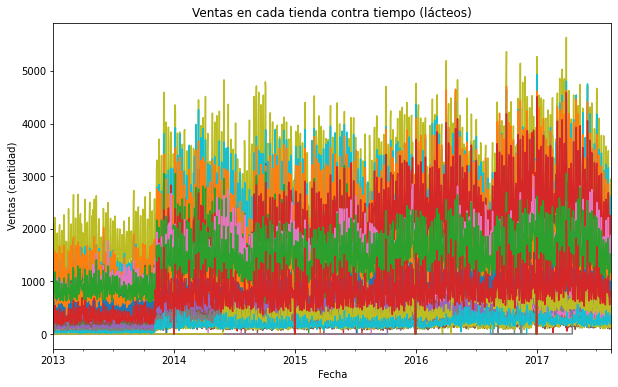

In [32]:
y = train.unstack(['store_nbr', 'family']).loc['2013':'2017']
family = {c[2] for c in train.index}
for f in family :
    if (f == "DAIRY"):
        ax = y.loc(axis = 1)['sales', :, f].plot(legend = None)
        ax.set_ylabel("Ventas (cantidad)")
        ax.set_xlabel("Fecha")
        ax.set_title("Ventas en cada tienda contra tiempo (lácteos)")

# Creación del modelo

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import xgboost as xgb


In [18]:
# vamos a definir nuestra y con el rango de fechas previamente definido 
y = train.unstack(['store_nbr', 'family']).loc['2017-04-30' :'2017-08-15']
# Para el Fourier, vamos a aplicar una frecuencia semanal de orden 3 en base a lo 
# observado en la frecuencia de los datos
fourier = CalendarFourier(freq = 'W', order = 3)

dp = DeterministicProcess(index = y.index,
                          order = 1,
                          seasonal = False,
                          constant = False,
                          additional_terms = [fourier],
                          drop = True)
x = dp.in_sample()
x = x.join(calendar)
x.head()

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",avg_oil,oil_lags_1,oil_lags_2,...,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
date,,,,,,,,,,,,,,,,,,,,,
2017-04-30,1.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,49.358571,49.358571,49.358571,...,0,0,0,1,0,0,0,0,0,0
2017-05-01,2.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,49.154286,49.358571,49.358571,...,0,0,0,0,0,0,0,1,0,0
2017-05-02,3.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,48.870000,49.154286,49.358571,...,0,0,0,0,0,0,0,0,0,0
2017-05-03,4.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,48.711429,48.870000,49.154286,...,0,0,0,0,0,0,0,0,0,0
2017-05-04,5.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,48.187143,48.711429,48.870000,...,1,0,0,0,0,0,0,0,0,0


In [19]:
# Hacemos el predict de los siguientes 16 dias
x_test = dp.out_of_sample(steps = 16)
x_test = x_test.join(calendar)
x_test.head()

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",avg_oil,oil_lags_1,oil_lags_2,...,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
2017-08-16,109.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,48.281429,48.648571,48.934286,...,0,0,0,0,0,0,0,0,0,0
2017-08-17,110.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,47.995714,48.281429,48.648571,...,1,0,0,0,0,0,0,0,0,0
2017-08-18,111.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,47.852857,47.995714,48.281429,...,0,1,0,0,0,0,0,0,0,0
2017-08-19,112.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,47.852857,47.852857,47.995714,...,0,0,1,0,0,0,0,0,0,0
2017-08-20,113.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,47.852857,47.852857,47.852857,...,0,0,0,1,0,0,0,0,0,0


In [20]:
linear_model = LinearRegression()
linear_model.fit(x, y)

rforest_model = RandomForestRegressor()
rforest_model.fit(x, y)


RandomForestRegressor()

In [21]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_log_error as msle
yfit_linear = pd.DataFrame(linear_model.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_linear = pd.DataFrame(linear_model.predict(x_test), index = x_test.index, columns = y.columns).clip(0.)
yfit_rforest = pd.DataFrame(rforest_model.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_rforest = pd.DataFrame(rforest_model.predict(x_test), index = x_test.index, columns = y.columns).clip(0.)
print('Linear RMSLE :', np.sqrt(msle(y, yfit_linear)))
print('Linear MAE :', mae(y, yfit_linear))
print('Random forest RMSLE :', np.sqrt(msle(y, yfit_rforest)))
print('Random forest MAE :', mae(y, yfit_rforest))

Linear RMSLE : 0.4056615254811359
Linear MAE : 55.2272310827509
Random forest RMSLE : 0.20340555123436335
Random forest MAE : 27.775733813036602


Vemos que los errores son considerablemente más bajos en el modelo de random forest, por lo que vamos a usarlo para hacer la predicción final

In [22]:

y_submit = ypred_rforest.stack(["store_nbr","family"])
y_submit

sales
           store_nbr family                                 
2017-08-16 1         AUTOMOTIVE                     5.450000
                     BABY CARE                      0.000000
                     BEAUTY                         3.460000
                     BEVERAGES                   2450.160000
                     BOOKS                          0.120000
...                                                      ...
2017-08-31 9         POULTRY                      328.306106
                     PREPARED FOODS                93.291650
                     PRODUCE                     1175.756980
                     SCHOOL AND OFFICE SUPPLIES    55.850000
                     SEAFOOD                       12.280630

[28512 rows x 1 columns]

In [23]:
df_test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [24]:
# Ahora vamos a agregar la predicción de ventas al df de test 
df_test["sales"] = y_submit.values

In [25]:
# Vemos que ya agregamos las ventas
df_test

,id,date,store_nbr,family,onpromotion,sales
0,3000888,2017-08-16,1,AUTOMOTIVE,0,5.450000
1,3000889,2017-08-16,1,BABY CARE,0,0.000000
2,3000890,2017-08-16,1,BEAUTY,2,3.460000
3,3000891,2017-08-16,1,BEVERAGES,20,2450.160000
4,3000892,2017-08-16,1,BOOKS,0,0.120000
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,328.306106
28508,3029396,2017-08-31,9,PREPARED FOODS,0,93.291650
28509,3029397,2017-08-31,9,PRODUCE,1,1175.756980
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,55.850000


In [26]:
# Dejamos solo las columnas necesarias para el submission
df_test = df_test[["id", "sales"]]

In [27]:
# Generamos el csv con las predicciones para hacer submit
df_test.to_csv('submission.csv', index=False)